# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [1]:
%matplotlib inline

In [2]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
# movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\k.castaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 1min 17s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [3]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [4]:
print(len(movies_tv))
print(movies_tv.head(5))

1697533
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [5]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 10.1 s


In [6]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.tail(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
1697528,"[1, 14]",wow $269.99 for the entire series on Blu Ray??...,1,Way to Expensive!! WB = GREED,1406073600,2014-07-23
1697529,"[32, 48]","Finally, the holy grail of tv-on-dvd boxsets i...",5,"HOLY BAT-BOXSET, BATMAN... I never thought thi...",1405641600,2014-07-18
1697530,"[3, 10]",Could this be a true or I'm i dreaming batman ...,5,prayers have been answered because batman 60s ...,1405728000,2014-07-19
1697531,"[0, 4]",I've been a fan of the series since I was a yo...,5,can't Wait!,1405987200,2014-07-22
1697532,"[11, 23]",People seriously need to wake up and realize t...,5,The Price is Insane? People Really Need to Wak...,1405728000,2014-07-19


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

**Answer.** 
The histograms show that the overall rating for movies and videos is mostly 5, so we can induce that there are a lot of good and excellent movies and videos.
UnixTimeReview in movies since time 9e+8 had slowly increased, however in 1.34e+9 it showed an increase of three times the amount of received reviews.
On the other hand, the number of reviews in the videos was not significant until the time of 1.35e+9, reaching its maximum at 1.39e+9.
It can be concluded that lately the number of reviews has increased.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
#movies_tv.describe()

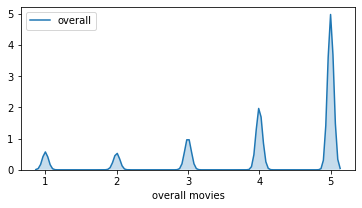

In [9]:
plt.figure(figsize=(6,3))
sns.kdeplot(movies_tv["overall"],shade=True)
plt.xlabel('overall movies');

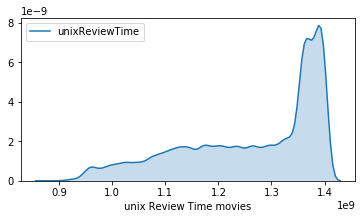

In [10]:
plt.figure(figsize=(6,3))
sns.kdeplot(movies_tv["unixReviewTime"],shade=True)
plt.xlabel('unix Review Time movies');

In [11]:
#instant_video.describe()

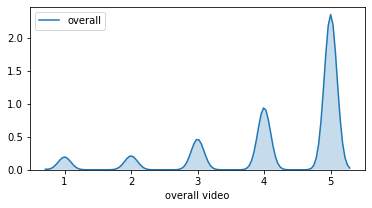

In [12]:
plt.figure(figsize=(6,3))
sns.kdeplot(instant_video["overall"],shade=True)
plt.xlabel('overall video');

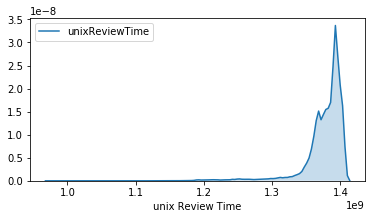

In [13]:
plt.figure(figsize=(6,3))
sns.kdeplot(instant_video["unixReviewTime"],shade=True)
plt.xlabel('unix Review Time');

--------

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

**Answer.** The average rating for movies remained stable around 4.0 until 2012 where the average rose to 4.3.
The average rating for videos reached its lowest level in 2004, but in 2006 the average rose to an average of 4.9, in the last years studied it remained at 4.3.

In [14]:
movies_tv['year'] = movies_tv['datetime'].dt.year

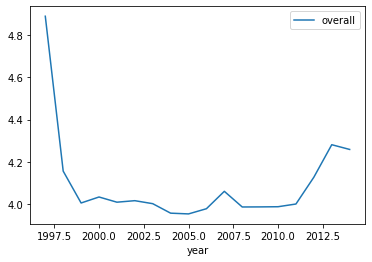

In [15]:
avg_rating= pd.DataFrame(movies_tv.groupby(["year"]).mean()["overall"])
avg_rating.plot()

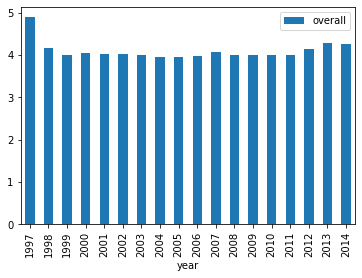

In [16]:
avg_rating.plot.bar()

In [17]:
instant_video['year'] = instant_video['datetime'].dt.year

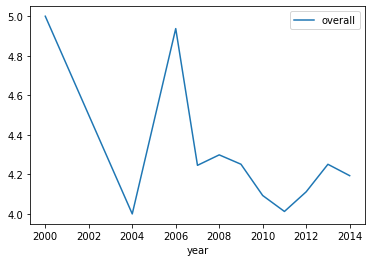

In [18]:
avg_ratingV= pd.DataFrame(instant_video.groupby(["year"]).mean()["overall"])
avg_ratingV.plot()

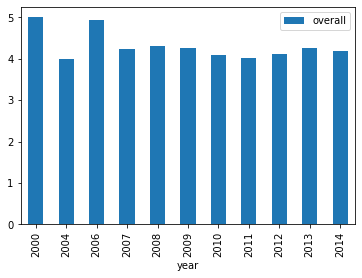

In [19]:
avg_ratingV.plot.bar()

--------

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

In [20]:
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy  as np
import string
import plotly
from nltk.stem import PorterStemmer 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\k.castaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\k.castaneda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
AllReviews = movies_tv['reviewText']
AllReviews.head()

0    This is a charming version of the classic Dick...
1    It was good but not as emotionally moving as t...
2    Don't get me wrong, Winkler is a wonderful cha...
3    Henry Winkler is very good in this twist on th...
4    This is one of the best Scrooge movies out.  H...
Name: reviewText, dtype: object

In [22]:
# Print text of first Yelp review
AllReviews[0]

'This is a charming version of the classic Dicken\'s tale.  Henry Winkler makes a good showing as the "Scrooge" character.  Even though you know what will happen this version has enough of a change to make it better that average.  If you love A Christmas Carol in any version, then you will love this.'

In [23]:
# sentence tokenization
sentences = nltk.sent_tokenize(AllReviews[0])
for sentence in sentences:
    print(sentence)
    print()

This is a charming version of the classic Dicken's tale.

Henry Winkler makes a good showing as the "Scrooge" character.

Even though you know what will happen this version has enough of a change to make it better that average.

If you love A Christmas Carol in any version, then you will love this.



In [24]:
sentences = nltk.sent_tokenize(movies_tv['reviewText'][1])
for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    print(sentence)
    print(words)
    print()

It was good but not as emotionally moving as the the Christmas Carol by Dickens  I like Christmas movies that make me sigh
['It', 'was', 'good', 'but', 'not', 'as', 'emotionally', 'moving', 'as', 'the', 'the', 'Christmas', 'Carol', 'by', 'Dickens', 'I', 'like', 'Christmas', 'movies', 'that', 'make', 'me', 'sigh']



In [ ]:
review_words_lengths = AllReviews.apply(lambda x: len(nltk.word_tokenize(x)))

In [ ]:
min(review_words_lengths)

In [ ]:
## This review has been written in a different language 
AllReviews[review_words_lengths[review_words_lengths == 2].index]

In [ ]:
max(review_words_lengths)

In [ ]:
AllReviews[review_words_lengths[review_words_lengths == max(review_words_lengths)].index]
## Setting the resolution for better clarity 
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
review_words_lengths.hist(bins = 25)

**Answer.**

--------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

**Answer.**

--------

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

**Answer.**

--------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

**Answer.**

--------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

**Answer.**

--------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

**Answer.**

--------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

--------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

--------